In [18]:
import rioxarray as rx
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os
import scipy.optimize as optimize
import geopandas as gpd
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
os.chdir('/disk/scratch/local.4/harry/TDX/')

# Cumlative Sum of Residuals Formula

def CSR(a):
    mean = np.mean(a, axis=0)
    resid = a - mean
    return np.nancumsum(resid,axis=0)

def get_max_CSR(a):
    return xr.apply_ufunc(CSR, a).max(dim='t')

def get_min_CSR(a):
    return xr.apply_ufunc(CSR,a).min(dim='t')

def get_pixelsize(ds):
    metres = ds.rename({'lat':'y','lon':'x'}).rio.reproject('EPSG:5389')
    print((metres.x[1]-metres.x[0]).values)
    
def my_pearson(X,Y):

    x = np.array(X).flatten()
    where = ~np.isnan(x)
    x = x[where]

    y = np.array(Y).flatten()
    y = y[where]
    
    r,p = pearsonr(x,y)
    
    plt.annotate("r = %.2f" % r+'\n' + "p = %.2g" % p, (0.1,0.85),xycoords='axes fraction')

In [19]:
# -------------------------------------------------------------------------------------------------
# Read in Data ------------------------------------------------------------------------------------

dem = xr.open_dataset('DEM_timeseries/DEM_timeseries_3m.nc')
asc = xr.open_dataset('intensity/nc/ascending.nc')
desc = xr.open_dataset('intensity/nc/descending.nc')
uav = '/exports/csce/datastore/geos/users/s1332488/Chapter3/intensity/UAV_change_1m_masked.tif'
uav = rx.open_rasterio(uav)
uav = uav.sel(band=1).drop('band').rio.reproject('EPSG:4326').rename({'x':'lon','y':'lat'})
uav = uav.coarsen(lat=3,lon=3,boundary='trim').mean()

# Make map of features before coarsening?
# plt.figure(figsize=(12,12))
########################################


# -------------------------------------------------------------------------------------------------
# Extract features and merge datasets
# -------------------------------------------------------------------------------------------------

AOI_lon, AOI_lat = slice(-69.73,-69.705) , slice(-11.015,-11.035)

keep  = [0,1,2,3,4,5,6,6,7,8,10,11,12,13,14,15,18,19,20,21]
dem   = dem.isel(t=keep)                                             # Remove images with artefacts
coh = dem.coherence.sel(lon=AOI_lon, lat=AOI_lat)   # Crop to AOI
dem = dem.height.sel(lon=AOI_lon, lat=AOI_lat)
uav = uav.sel(lon=AOI_lon, lat=AOI_lat)
asc = asc.sel(lon=AOI_lon, lat=AOI_lat)
desc = desc.sel(lon=AOI_lon, lat=AOI_lat)

# Firstly DEM / coherence data and UAV data. Pixel size is 3m
uavD  = uav.where(uav > -100).interp_like(dem,method='nearest').rename('uav')         # Regrid to match TDX
h_csr = get_max_CSR(dem)                                             # Change detection feature height
trend = dem.polyfit('t',1).sel(degree=1).polyfit_coefficients        # Slope of height change
trend = (trend * (dem.t[-1] - dem.t[0]).astype(np.float64)   )       # Converted to metres
dem   = xr.merge([uavD,h_csr.rename('x0'),trend.rename('x1')])       # Merge datasets                     
# weights = coh.mean(dim='t')                                          # Coarsen to 50 m with weights?
# [[Weights via coherence did not result in any improvements...]]
#--------------------------------------------------------------------------------------------------
# weighted_x0 = (dem.x0*weights).coarsen(lat=15,lon=15,boundary='trim').sum() 
# weighted_x0 = weighted_x0 / weights.coarsen(lat=15,lon=15,boundary='trim').sum()
# weighted_x1 = (dem.x1*weights).coarsen(lat=15,lon=15,boundary='trim').sum() 
# weighted_x1 = weighted_x1 / weights.coarsen(lat=15,lon=15,boundary='trim').sum()
# uav_coarse = dem.uav.coarsen(lat=15,lon=15,boundary='trim').mean()
# dem   = xr.merge([uav_coarse.rename('uav'),weighted_x0.rename('x0'),weighted_x1.rename('x1')])
#--------------------------------------------------------------------------------------------------
# ax=plt.subplot(2,2,1)
# dem.uav.plot(vmin=-15,vmax=15)
# plt.xlim(-69.725,-69.715)
# plt.ylim(-11.025,-11.015)
# ax.set_facecolor('#c9c9c9')


# ax=plt.subplot(2,2,2)
# dem.x1.where(dem.uav>-100).plot(vmin=-15,vmax=15)
# plt.xlim(-69.725,-69.715)
# plt.ylim(-11.025,-11.015)
# ax.set_facecolor('#c9c9c9')
# dem.x1.rio.to_raster('/exports/csce/datastore/geos/users/s1332488/Chapter3/DEM/heightTrend3m.tif')
# dem.uav.rio.to_raster('/exports/csce/datastore/geos/users/s1332488/Chapter3/DEM/UAV.tif')
dem = dem.coarsen(lat=17,lon=17,boundary='trim').mean()

coh   = xr.merge([uavD,coh.rename('coh')])                          # Merge datasets

# Now intensity data. Pixel size is 2.65m

# uavI = uav.where(uav > -100).interp_like(desc).rename('uav')  # Regrid to match TDX
asc  = get_max_CSR(asc).intensity.rename('x0').interp_like(uavD,method='nearest')                 # Change detection feature ascending
desc = get_max_CSR(desc).intensity.rename('x1') .interp_like(uavD,method='nearest')               # Change detection feature descending
intensity = xr.merge([uavD,asc,desc]).coarsen(lat=17,lon=17,boundary='trim').mean()   # Merge datasets
# intensity.x0.rio.to_raster('/exports/csce/datastore/geos/users/s1332488/Chapter3/intensity/CSR_A.tif')
# intensity.x1.rio.to_raster('/exports/csce/datastore/geos/users/s1332488/Chapter3/intensity/CSR_D.tif')
# ax=plt.subplot(2,2,3)
# intensity.x0.where(intensity.uav>-100).plot.imshow(vmin=24,vmax=-12,cmap='viridis_r')
# plt.xlim(-69.725,-69.715)
# plt.ylim(-11.025,-11.015)
# ax.set_facecolor('#c9c9c9')


# ax=plt.subplot(2,2,4)
# intensity.x1.where(intensity.uav>-100).plot.imshow(vmin=50,vmax=-25,cmap='viridis_r')
# plt.xlim(-69.725,-69.715)
# plt.ylim(-11.025,-11.015)
# ax.set_facecolor('#c9c9c9')


# intensity = intensity.coarsen(lat=10,lon=10,boundary='trim').mean()      # Coarsen to 50 m
# -------------------------------------------------------------------------------------------------

# Find stats on coherence layer at 1/4 ha
coh['anom'] = coh.coh - coh.coh.mean(dim=['lat','lon'])  # Remove trend due to HoA
coh_std = coh.anom.coarsen(lat=17,lon=17,boundary='trim').std()
coh_uav = coh.uav.coarsen(lat=17,lon=17,boundary='trim').mean()
coh_x0 = get_max_CSR(coh.anom).coarsen(lat=17,lon=17,boundary='trim').mean()
coh_x1 = coh_std.polyfit('t',1).sel(degree=1).polyfit_coefficients
coh_x1 = coh_x1 * (coh_std.t[-1] - coh_std.t[0]).astype(np.float64) 
coh = xr.merge([coh_uav.rename('uav'), coh_x0.rename('x0'), coh_x1.rename('x1')])

# Double check pixel sizes and extents
print('DEM pixel size')
get_pixelsize(dem)
get_pixelsize(coh)
print('Intensity pixel size')
get_pixelsize(intensity)

/exports/csce/datastore/geos/users/s1332488/minibonda/envs/XR/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


DEM pixel size
49.86959210905479
49.86959210905479
Intensity pixel size
49.86959210905479


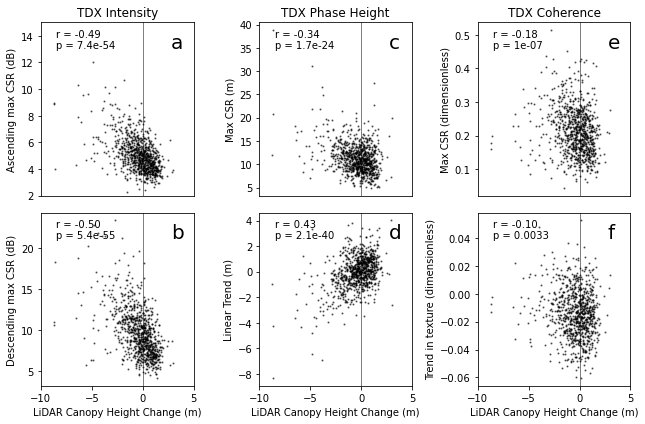

In [20]:

plt.figure(figsize=(9,6))
plt.subplot(2,3,2)
my_pearson(dem.uav,dem.x0)
dem.plot.scatter(x='uav',y='x0',alpha=0.5,s=5,color='black',marker='.')#,label="r = %.2f" % c)
plt.ylabel('Max CSR (m)')
plt.title('TDX Phase Height')
plt.axvline(x=0,color='black',lw=1,alpha=0.5)
plt.xlim(-10,5)
plt.xticks([])
plt.xlabel('')
# plt.legend(loc='upper left')
plt.annotate('c',(0.85,0.85),xycoords='axes fraction',size=20)

plt.subplot(2,3,5)
my_pearson(dem.uav,dem.x1)
dem.plot.scatter(x='uav',y='x1',alpha=0.5,s=5,color='black',marker='.')#,label="r = %.2f" % c)
plt.title('')
plt.ylabel('Linear Trend (m)')
plt.axvline(x=0,color='black',lw=1,alpha=0.5)
plt.xlim(-10,5)
# plt.xticks([])
# plt.xlabel('')
# plt.legend(loc='upper left')
plt.xlabel('LiDAR Canopy Height Change (m)')
plt.annotate('d',(0.85,0.85),xycoords='axes fraction',size=20)
#---------
plt.subplot(2,3,1)
my_pearson(intensity.uav,intensity.x0)
intensity.plot.scatter(x='uav',y='x0',alpha=0.5,s=5,color='black',marker='.')#,label="r = %.2f" % c)
plt.ylabel('Ascending max CSR (dB)')
plt.title('TDX Intensity')
plt.axvline(x=0,color='black',lw=1,alpha=0.5)
plt.xlim(-10,5)
plt.ylim(2,15)
plt.xticks([])
plt.xlabel('')
# plt.legend(loc='upper left')
plt.annotate('a',(0.85,0.85),xycoords='axes fraction',size=20)

plt.subplot(2,3,4)
my_pearson(intensity.uav, intensity.x1)
intensity.plot.scatter(x='uav',y='x1',alpha=0.5,s=5,color='black',marker='.')#,label="r = %.2f" % c)
plt.title('')
plt.axvline(x=0,color='black',lw=1,alpha=0.5)
plt.ylabel('Descending max CSR (dB)')
plt.xlim(-10,5)
# plt.xticks([])
# plt.xlabel('')
# plt.legend(loc='upper left')
plt.xlabel('LiDAR Canopy Height Change (m)')
plt.annotate('b',(0.85,0.85),xycoords='axes fraction',size=20)
#---------
plt.subplot(2,3,3)
my_pearson(coh.uav, coh.x0)
coh.plot.scatter(x='uav',y='x0',alpha=0.5,s=5,color='black',marker='.')#,label="r = %.2f" % c)
plt.title('TDX Coherence')
plt.ylabel('Max CSR (dimensionless)')
plt.axvline(x=0,color='black',lw=1,alpha=0.5)
plt.xlim(-10,5)
plt.xticks([])
plt.xlabel('')
# plt.xlabel('UAV LiDAR Canopy Height Change (m)')
# plt.legend(loc='upper left')
plt.annotate('e',(0.85,0.85),xycoords='axes fraction',size=20)

plt.subplot(2,3,6)
my_pearson(coh.uav, coh.x1)
coh.plot.scatter(x='uav',y='x1',alpha=0.5,s=5,color='black',marker='.')#,label="r = %.2f" % c)
plt.title('')
plt.axvline(x=0,color='black',lw=1,alpha=0.5)
plt.ylabel('Trend in texture (dimensionless)')
plt.xlim(-10,5)
plt.xlabel('LiDAR Canopy Height Change (m)')
# plt.legend(loc='upper left')
plt.annotate('f',(0.85,0.85),xycoords='axes fraction',size=20)

plt.tight_layout()
plt.savefig('/home/s1332488/Chapter3/Figures/correlations.png')

In [67]:
# Read in training area and testing area
train_aoi = gpd.read_file('/home/s1332488/Chapter3/Figures/Ph_ts/train_area.shp')
test_aoi = gpd.read_file('/home/s1332488/Chapter3/Figures/Ph_ts/test.shp')

# Define routine to optimize linear model with two features as inputs (3 parameters)

def model(ds,p0,p1,p2):
    return p0 * ds.x0 + p1 * ds.x1 + p2

def cost_fn(p,ds):
    estimate = model(ds,p[0],p[1],p[2])
    return np.sqrt( ((estimate-ds.uav)**2).sum() ).values

def fit_model(ds):
    ds = ds[['uav','x0','x1']]
    trainData = ds.rio.clip(train_aoi.geometry).where(ds.uav > -100)
    result = optimize.minimize(cost_fn,[-1,1,0],args=trainData,method='Nelder-Mead')
    print(result.message)
    print('Parameters: ',result.x)
    p = result.x
    ds['pred'] = model(ds,p[0],p[1],p[2])    
    print('r = ',xr.corr(ds.uav,ds.pred).values)
    return ds.pred

# Fit models to the three datasets
# print('DEM----')
# dem['pred']=fit_model(dem)
# print('COH----')
# coh['pred']=fit_model(coh)
# print('INT----')
# intensity['pred']=fit_model(intensity)

In [90]:
def norm(da):
    return ( da - da.mean() )/ da.std()
intensity['x0'] = norm(intensity.x0)
intensity['x1'] = norm(intensity.x1)
dem['x0'] = norm(dem.x0)
dem['x1'] = norm(dem.x1)
coh['x0'] = norm(coh.x0)
coh['x1'] = norm(coh.x1)

In [91]:
def skl_fit(ds):
    ds = ds[['uav','x0','x1']]
    trainData = ds.rio.clip(train_aoi.geometry)
    x0 = trainData.x0.values.flatten()
    x1 = trainData.x1.values.flatten()
    y = trainData.uav.values.flatten()

    where = y>-100
    x0 = x0[where]
    x1 = x1[where]
    y = y[where]
    X = np.array([x0,x1]).transpose()
    reg = LinearRegression()
    reg.fit(X,y)

    print(reg.coef_,reg.intercept_)
    
    return lambda x: x.x0* reg.coef_[0] + x.x1*reg.coef_[1] + reg.intercept_

dem['pred']=skl_fit(dem)(dem)
intensity['pred']=skl_fit(intensity)(intensity)
coh['pred'] = skl_fit(coh)(coh)

[0.02280456 0.58009987] -0.6591788088158554
[-0.59682442 -0.37054938] -0.5698346095112774
[-0.28117312 -0.04389947] -0.611674102087087


In [92]:
combo = xr.Dataset({'uav':dem.uav,'x0':dem.pred,'x1':intensity.pred})
combo['pred'] = skl_fit(combo)(combo)

[0.62643604 0.85139307] 0.2766990454990802


**
intensity
Detection Rate:  0.6923076923076923
false alarm rate:  0.32258064516129037
Accuracy:  0.8440860215053764
Growth Detection Rate:  0.0
**
phase height
Detection Rate:  0.5054945054945055
false alarm rate:  0.45882352941176474
Accuracy:  0.7741935483870968
Growth Detection Rate:  0.0
**
combo
Detection Rate:  0.7032967032967034
false alarm rate:  0.2558139534883721
Accuracy:  0.8682795698924731
Growth Detection Rate:  0.0


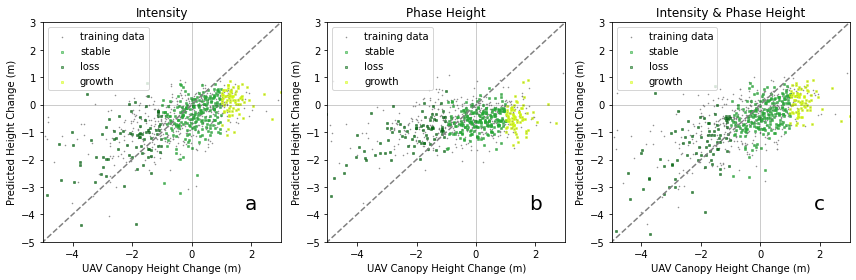

*****
Total degradation rate:  0.28222996515679444


In [95]:
def plot_results(ds):
    testData = ds.rio.clip(test_aoi.geometry).where(ds.uav > -100)
    trainData = ds
    plt.axvline(x=0,alpha=0.2,lw=1,color='black')
    plt.axhline(y=0,alpha=0.2,lw=1,color='black')
#     plt.plot([1,1],[1,3],alpha=0.2,lw=1,color='black')
#     plt.plot([1,3],[1,1],alpha=0.2,lw=1,color='black')
#     plt.plot([-1,-1],[-1,-7],alpha=0.2,lw=1,color='black')
#     plt.plot([-1,-7],[-1,-1],alpha=0.2,lw=1,color='black')
    plt.plot([-7,3],[-7,3],color='grey',ls='--')
    noChange = testData.where((testData.uav >= -1)*(testData.uav <= 1))
    fall = testData.where(testData.uav<-1)
    grow = testData.where(testData.uav>1)
    trainData.plot.scatter(x='uav',y='pred',s=1,color='grey',marker='.',label='training data')
    noChange.plot.scatter(x='uav',y='pred',s=2,color='#22ab34',marker='s',alpha=0.5,label='stable')
    fall.plot.scatter(x='uav',y='pred',s=2,color='#00660e',marker='s',alpha=0.5,label='loss')
    grow.plot.scatter(x='uav',y='pred',s=2,color='#d4fc0d',marker='s',alpha=0.5,label='growth')
    plt.xlabel('UAV Canopy Height Change (m)')
    plt.ylabel('Predicted Height Change (m)')
    
    positives = ((testData.uav < -1)*(testData.uav > -100)).sum()
    flagged = (testData.pred < -1).sum()
    true_pos = ((testData.uav < -1) * (testData.pred < -1)).sum()
    detection_rate = true_pos/positives
    false_alarms = 1 - (true_pos/flagged)
    true_neg = ((testData.uav >= -1)* (testData.pred >= -1)).sum()
    accuracy = (true_pos + true_neg)/(testData.uav > -100).sum()
    print('Detection Rate: ',detection_rate.values)
    print('false alarm rate: ',false_alarms.values)
    print('Accuracy: ',accuracy.values)
    
    growth_pixels = (testData.uav >1).sum()
    detected_growth = ((testData.uav >1)*(testData.pred >1)).sum()
    print('Growth Detection Rate: ',(detected_growth/growth_pixels).values)
    
    
    plt.xlim(-5,3)
    plt.ylim(-5,3)
    plt.legend(loc='upper left')
    
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
print('**')
print('intensity')
plot_results(intensity)
plt.title('Intensity')
plt.annotate('a',(0.85,0.15),xycoords='axes fraction',size=20)


plt.subplot(1,3,2)
print('**')
print('phase height')
plot_results(dem)
plt.title('Phase Height')
plt.annotate('b',(0.85,0.15),xycoords='axes fraction',size=20)

plt.subplot(1,3,3)
print('**')
print('combo')
plot_results(combo)
plt.title('Intensity & Phase Height')
plt.annotate('c',(0.85,0.15),xycoords='axes fraction',size=20)
plt.tight_layout()
plt.savefig('/home/s1332488/Chapter3/Figures/change_detection.png',dpi=400)
plt.show()
print('*****')
print('Total degradation rate: ',  (((dem.uav < -1).sum()) / ((dem.uav>-100).sum()) ).values )